In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import os
import tqdm
from collections import namedtuple

In [4]:
import glob, time

In [5]:
from pymono.cnn_fit import fit_coord, plotfxyz

In [13]:
from pymono.cnn_xevent import event_size, event_ekin, select_gammas_interact_in_crystal
from pymono.cnn_xevent import xindex, yindex,zindex,voxelize, filter_df, concat_df, streams
from pymono.cnn_xevent import filter_and_voxelize_df, mean_XYZ, compute_xyz


## Functions

In [14]:
def histoplot(var, xlabel, ylabel, bins=100, figsize=(4,4), title=""):
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    h = plt.hist(var,bins)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return h[0],h[1]

In [15]:
def prgroup(grdf, ng=1):
    i = 1
    for name, group in grdf:
        print(f"Group: {name}")
        print(group, "\n")
        i+=1
        if i > ng:
            break

In [16]:
def pixelated(gdfx,mcrst,sx,sy,sz, ecut, case='pixel'):
    gdf = voxelize(gdfx,mcrst,sx,sy,sz, ecut)
    gdf =gdf[gdf.ebox >ecut]
    return event_size(gdf)

In [17]:
def compute_deltas(df):
    grdf = df.groupby('event_id')
    DX1 = []
    DY1 = []
    DZ1 = []

    for name, gr in grdf:
        DX1.extend(np.diff(gr.x))
        DY1.extend(np.diff(gr.y))
        DZ1.extend(np.diff(gr.z))

    return np.array(DX1),np.array(DY1),np.array(DZ1)

In [18]:
def plotddx(DX,DY,DZ,bins=100, figsize=(8,8), cut=1.0):
    fig, ax = plt.subplots(2, 3, figsize=figsize)
        
    h00 = ax[0,0].hist(DX,bins)
    ax[0,0].set_xlabel("Dx (mm)")
    ax[0,0].set_ylabel("entries")
    
    h01 = ax[0,1].hist(DY,bins)
    ax[0,1].set_xlabel("Dy (mm)")
    ax[0,1].set_ylabel("entries")
    
    h02 = ax[0,2].hist(DZ,bins)
    ax[0,2].set_xlabel("Dz (mm)")
    ax[0,2].set_ylabel("entries")
    
    h10 = ax[1,0].hist(DX[np.abs(DX)>cut],bins)
    ax[1,0].set_xlabel("Dx1 (mm)")
    ax[1,0].set_ylabel("entries")

    h11 = ax[1,1].hist(DY[np.abs(DY)>cut],bins)
    ax[1,1].set_xlabel("Dy1 (mm)")
    ax[1,1].set_ylabel("entries")
   
    h12 = ax[1,2].hist(DZ[np.abs(DZ)>cut],bins)
    ax[1,2].set_xlabel("Dz1 (mm)")
    ax[1,2].set_ylabel("entries")
    
    fig.tight_layout()
    plt.show()
  

In [19]:
def plotboxd(gdf,bins=100, cut=0.05, figsize=(8,8)):
   
    fig, ax = plt.subplots(2, 2, figsize=figsize)
    dx =gdf.x1 - gdf.xbox
    dy =gdf.y1 - gdf.ybox
    dz =gdf.z1 - gdf.zbox
    
    h00 = ax[0,0].hist(dx[np.abs(dx)>cut],bins)
    ax[0,0].set_xlabel("Dx (mm)")
    ax[0,0].set_ylabel("entries")
    
    h01 = ax[0,1].hist(dy[np.abs(dy)>cut],bins)
    ax[0,1].set_xlabel("Dy (mm)")
    ax[0,1].set_ylabel("entries")
    
    h02 = ax[1,0].hist(dz[np.abs(dz)>cut],bins)
    ax[1,0].set_xlabel("Dz (mm)")
    ax[1,0].set_ylabel("entries")
    
    h10 = ax[1,1].hist(dx,bins)
    ax[1,1].set_xlabel("Dx1 (mm)")
    ax[1,1].set_ylabel("entries")
    
    fig.tight_layout()
    plt.show()

## Code

In [20]:
path_to_data=os.environ['MONOLITH_DATA'] 
npr=10
eth = 0.001 # in keV
lmax = 50 # in mm
dir = os.path.join(path_to_data,"LYSO_6x6_nowrap_15k_2MHzDC_PTFE_LUT_gamma_NX")
# Define the pattern to match all .txt files in the 'documents' directory
pattern = f'{dir}/*.h5'

# Use glob to find all files matching the pattern
file_paths = glob.glob(pattern)



In [21]:
len(file_paths)

100

### Compute crystal dimensions

In [22]:
XYZ = compute_xyz(file_paths, start=0, end=5, eth=0.001, lmax=49, bins=100, prnt=100)

Reading data frame 0
Remove particles not coming from primaryC


In [23]:
xyzc = mean_XYZ(XYZ)

In [24]:
xyzc

MCrst(xmin=-23.0, xmax=23.0, dx=46.0, ymin=-23.0, ymax=23.0, dy=46.0, zmin=-2.0, zmax=24.0, dz=26.0)

##  Filter and reduce the DF
    1. Select events in which gammas interact in crystal
    2. Remove primary gammas
    3. Impose threshold in energy and length
    4. Drop columns not needed, create columns needed for barycenter and rename fields
    5. Concat files

In [25]:
gdf = filter_df(file_paths, start=0, end=5, eth=0.001, lmax=50, prnt=5)

Reading data frame 0
Select events in which gammas interact in crystal:
Remove primary gammas: 
Remove particles not coming from primaryC
Impose threshold in energy and length
Drop some extra columns and rename fields
Compute xiEi, yiEi, ziEi
now concat:


In [26]:
gdf.columns

Index(['event_id', 'particle_id', 'particle_name', 'x', 'y', 'z', 'initial_t',
       'E', 'creator_proc', 'xE', 'yE', 'zE'],
      dtype='object')

In [27]:
gdf.head(10)

,event_id,particle_id,particle_name,x,y,z,initial_t,E,creator_proc,xE,yE,zE
0,350000,2,e-,16.179787,-10.170916,2.357410,0.052875,0.082385,compt,1.332965,-0.837926,0.194214
1,350000,2428,e-,9.002096,-9.153288,12.413297,0.094226,0.002182,phot,0.019645,-0.019975,0.027089
2,350000,2426,e-,9.002096,-9.153288,12.413297,0.094226,0.004969,phot,0.044732,-0.045484,0.061683
3,350000,2424,e-,9.002096,-9.153288,12.413297,0.094226,0.418231,phot,3.764957,-3.828191,5.191628
4,350001,2,e-,9.626169,-20.355307,18.052013,0.104568,0.141369,compt,1.360840,-2.877606,2.551992
5,350001,4332,gamma,13.216259,-23.360641,21.935503,0.124858,0.008722,phot,0.115275,-0.203756,0.191326
6,350001,4331,gamma,13.216259,-23.360641,21.935503,0.124858,0.053069,phot,0.701374,-1.239726,1.164095
7,350001,4330,e-,13.216259,-23.360641,21.935503,0.124858,0.306011,phot,4.044324,-7.148619,6.712511
8,350002,2,e-,-23.652182,-18.856363,10.261168,0.079840,0.320924,compt,-7.590549,-6.051456,3.293053
9,350002,9703,e-,-22.734610,-17.350821,8.801526,0.087475,0.001242,phot,-0.028239,-0.021551,0.010932


### Compute the flight distance of e- in crystal

In [28]:
DX,DY,DZ = compute_deltas(gdf)

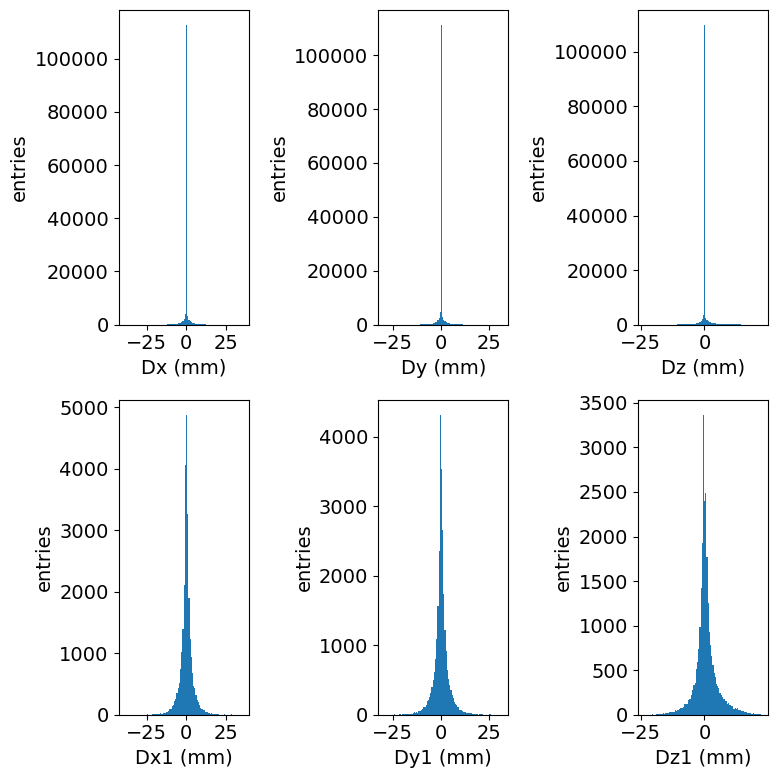

In [29]:
plotddx(DX,DY,DZ,bins=100, figsize=(8,8), cut=0.1)

In [30]:
f2gz, f2gx, f2gy = fit_coord(DX[np.abs(DX)>0.1], DY[np.abs(DY)>0.1], DZ[np.abs(DZ)>0.1], bins=100)

2g fit: mu1 = 0.64, sigma = 4.08, n1  =0.25
2g fit: mu2 = -0.08, sigma = 0.91, n1  =0.75
weighted error: = 1.69
2g fit: mu1 = 0.01, sigma = 3.56, n1  =0.28
2g fit: mu2 = -0.04, sigma = 0.84, n1  =0.72
weighted error: = 1.59
2g fit: mu1 = 0.12, sigma = 3.25, n1  =0.31
2g fit: mu2 = -0.11, sigma = 0.78, n1  =0.69
weighted error: = 1.53


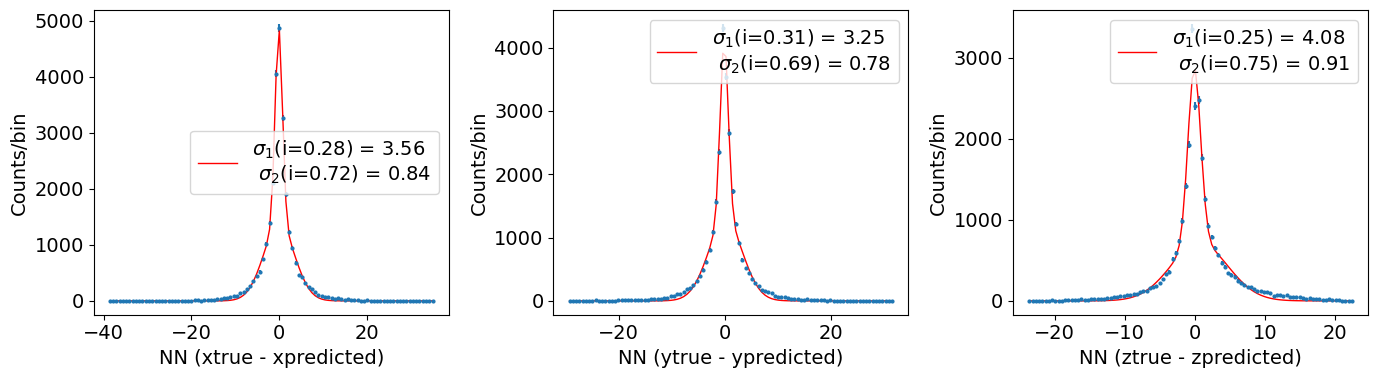

In [31]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

#### Flight distance
- In all coordinates, after cutoff (which eliminates low energy tracks) two components (70/30), at ~1 mm and ~5 mm. 

## Voxelize crystal (12mm)

In [32]:
gdfb = voxelize(gdf,xyzc,1, sx=12,sy=12,sz=12,case='mono', prnt=1)

nx = 3, ny = 3, nz = 2
number of voxels = 18
index for xmin =0.0 index for xmax =3.0
index for ymin =0.0 index for ymax =3.0
index for zmin =0.0 index for zmax =2.0


In [33]:
gdfb.head(10)

,event_id,ix,iy,iz,ebox,tbox,x1,y1,z1,xbox,ybox,zbox,nbox
0,230000,2,2,0,0.510343,0.051041,2.682876,6.252354,2.089536,2.711345,6.191158,2.087654,4
1,230001,2,1,0,0.510677,0.063438,7.941541,-4.121480,5.963039,7.941541,-4.121480,5.963039,5
2,230002,1,1,0,0.017795,0.084000,-1.266496,-4.872493,5.575497,-1.266496,-4.872493,5.575497,2
3,230002,1,1,1,0.285674,0.118141,-7.110951,-9.030653,12.876881,-7.110952,-9.030653,12.876882,5
4,230002,2,1,0,0.206283,0.053482,6.165669,-0.411802,2.647555,6.165668,-0.411802,2.647555,1
5,230003,2,2,1,0.509240,0.099861,3.112692,5.947286,15.727846,3.514397,5.677623,15.404912,6
6,230004,3,1,1,0.510338,0.078307,16.455788,-4.393598,10.138004,16.455788,-4.393598,10.138004,3
7,230006,0,3,0,0.508501,0.055475,-14.021806,15.300660,3.284433,-14.021806,15.300660,3.284433,1
8,230007,2,0,0,0.508642,0.062506,6.375220,-13.863320,5.754691,6.318707,-14.728883,5.665463,7
9,230008,-1,2,0,0.508845,0.071596,-23.878338,11.225692,7.588628,-23.868135,11.221527,7.589588,3


### Difference between barycenter (xbox) and first interaction (x1)

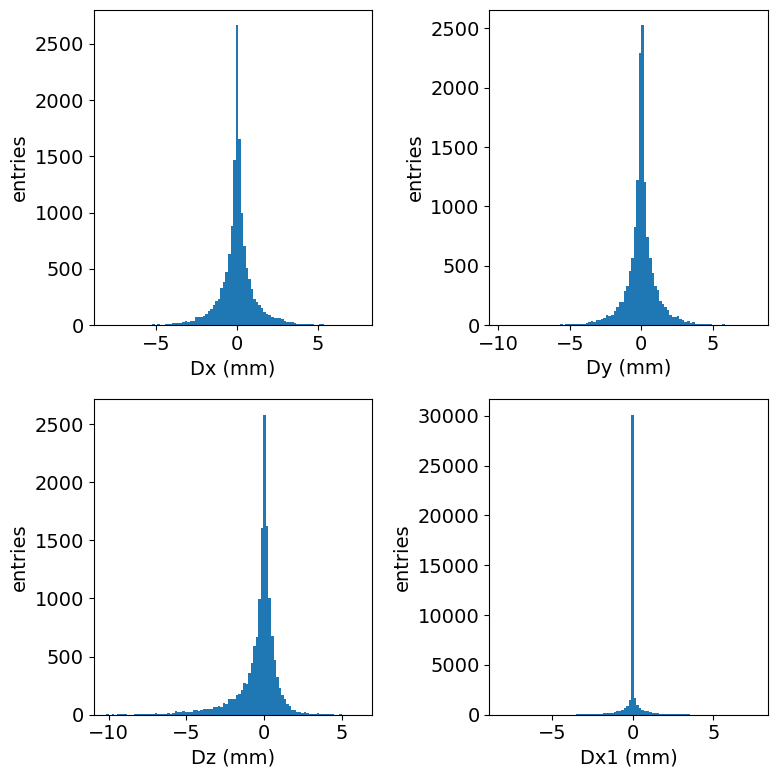

In [34]:
plotboxd(gdfb,bins=100, cut=0.01, figsize=(8,8))

In [35]:
dx =gdfb.x1 - gdfb.xbox
dy =gdfb.y1 - gdfb.ybox
dz =gdfb.z1 - gdfb.zbox
f2gz, f2gx, f2gy = fit_coord(dz[np.abs(dz)>0.01], dx[np.abs(dx)>0.01], dy[np.abs(dy)>0.01], bins=100)

2g fit: mu1 = -0.01, sigma = 0.90, n1  =0.27
2g fit: mu2 = 0.02, sigma = 0.17, n1  =0.73
weighted error: = 0.36
2g fit: mu1 = 0.05, sigma = 0.15, n1  =0.69
2g fit: mu2 = -0.06, sigma = 0.78, n1  =0.31
weighted error: = 0.34
2g fit: mu1 = 0.01, sigma = 0.77, n1  =0.30
2g fit: mu2 = -0.00, sigma = 0.13, n1  =0.70
weighted error: = 0.32


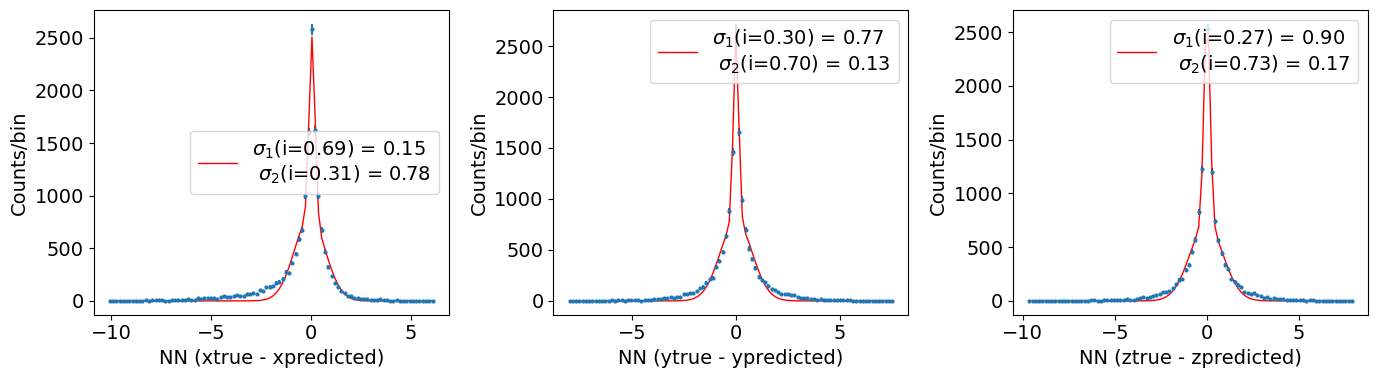

In [36]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

#### x1 -xbox
- In all coordinates, after cutoff (which eliminates low energy tracks) two components (75/25), at ~0.15 mm and ~0.8 mm. 

In [37]:
 df1c, df2c, dfnc =streams(gdfb, 1, 1)

 fraction of events 1g = 0.72
 fraction of events 2g = 0.25
 fraction of events >3g = 0.04


## Voxelize crystal (9mm)

In [38]:
gdfb = voxelize(gdf,xyzc,1, sx=9,sy=9,sz=9,case='mono', prnt=1)

nx = 5, ny = 5, nz = 2
number of voxels = 50
index for xmin =0.0 index for xmax =5.0
index for ymin =0.0 index for ymax =5.0
index for zmin =0.0 index for zmax =2.0


In [40]:
gdf.head(10)

,event_id,particle_id,particle_name,x,y,z,initial_t,E,creator_proc,xE,yE,zE
0,350000,2,e-,16.179787,-10.170916,2.357410,0.052875,0.082385,compt,1.332965,-0.837926,0.194214
1,350000,2428,e-,9.002096,-9.153288,12.413297,0.094226,0.002182,phot,0.019645,-0.019975,0.027089
2,350000,2426,e-,9.002096,-9.153288,12.413297,0.094226,0.004969,phot,0.044732,-0.045484,0.061683
3,350000,2424,e-,9.002096,-9.153288,12.413297,0.094226,0.418231,phot,3.764957,-3.828191,5.191628
4,350001,2,e-,9.626169,-20.355307,18.052013,0.104568,0.141369,compt,1.360840,-2.877606,2.551992
5,350001,4332,gamma,13.216259,-23.360641,21.935503,0.124858,0.008722,phot,0.115275,-0.203756,0.191326
6,350001,4331,gamma,13.216259,-23.360641,21.935503,0.124858,0.053069,phot,0.701374,-1.239726,1.164095
7,350001,4330,e-,13.216259,-23.360641,21.935503,0.124858,0.306011,phot,4.044324,-7.148619,6.712511
8,350002,2,e-,-23.652182,-18.856363,10.261168,0.079840,0.320924,compt,-7.590549,-6.051456,3.293053
9,350002,9703,e-,-22.734610,-17.350821,8.801526,0.087475,0.001242,phot,-0.028239,-0.021551,0.010932


### Difference between barycenter (xbox) and first interaction (x1)

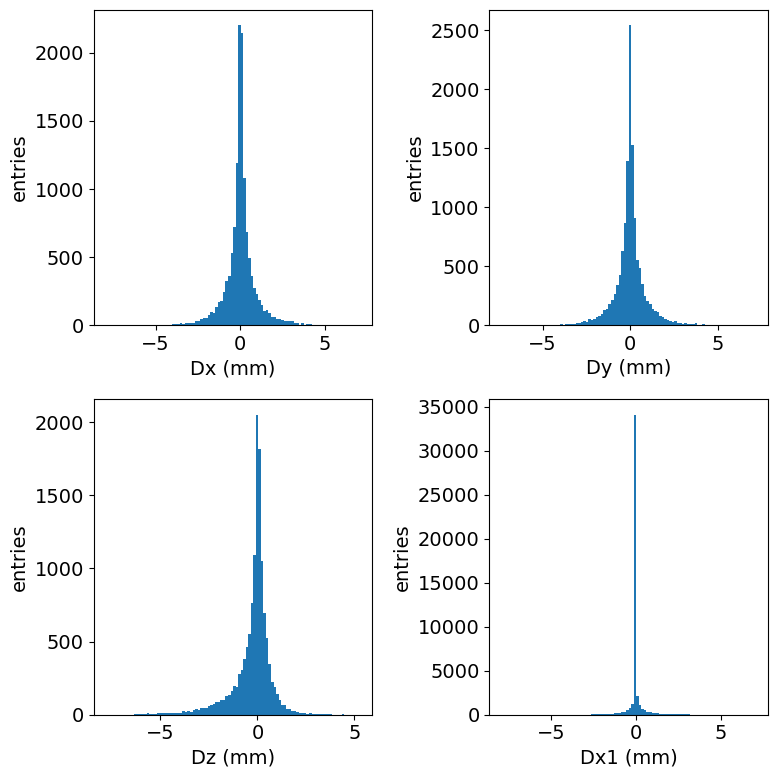

In [41]:
plotboxd(gdfb,bins=100, cut=0.01, figsize=(8,8))

In [42]:
dx =gdfb.x1 - gdfb.xbox
dy =gdfb.y1 - gdfb.ybox
dz =gdfb.z1 - gdfb.zbox
f2gz, f2gx, f2gy = fit_coord(dz[np.abs(dz)>0.01], dx[np.abs(dx)>0.01], dy[np.abs(dy)>0.01], bins=100)

2g fit: mu1 = -0.00, sigma = 0.11, n1  =0.70
2g fit: mu2 = -0.01, sigma = 0.64, n1  =0.30
weighted error: = 0.27
2g fit: mu1 = -0.07, sigma = 0.70, n1  =0.30
2g fit: mu2 = 0.04, sigma = 0.14, n1  =0.70
weighted error: = 0.30
2g fit: mu1 = 0.01, sigma = 0.15, n1  =0.74
2g fit: mu2 = -0.00, sigma = 0.77, n1  =0.26
weighted error: = 0.31


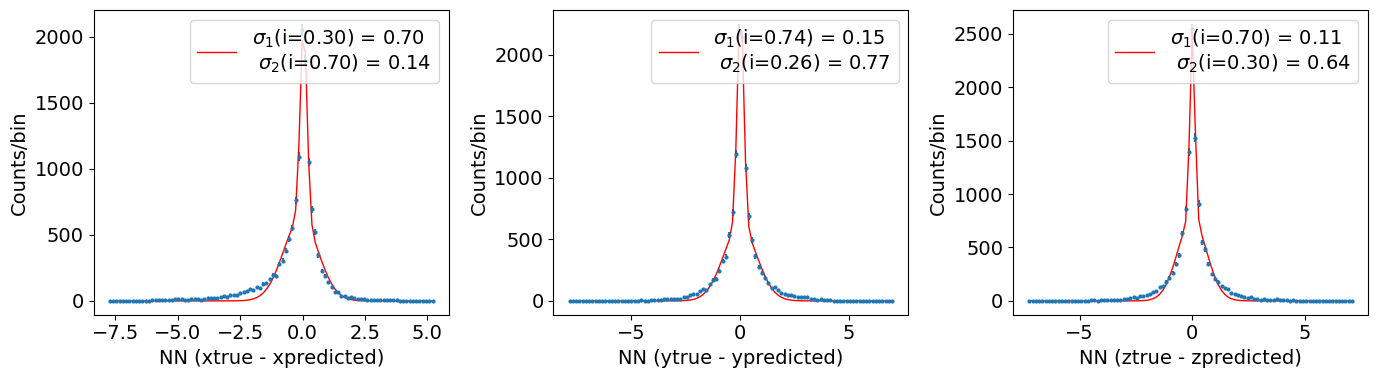

In [43]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

#### x1 -xbox
- In all coordinates, after cutoff (which eliminates low energy tracks) two components (70/30), at ~0.14 mm and ~0.7 mm. 

In [44]:
 df1c, df2c, dfnc =streams(gdfb, 1, 1)

 fraction of events 1g = 0.65
 fraction of events 2g = 0.29
 fraction of events >3g = 0.06


## Voxelize at 6 mm

In [45]:
gdfb = voxelize(gdf,xyzc,1, sx=6,sy=6,sz=6,case='mono', prnt=1)

nx = 7, ny = 7, nz = 4
number of voxels = 196
index for xmin =0.0 index for xmax =7.0
index for ymin =0.0 index for ymax =7.0
index for zmin =0.0 index for zmax =4.0


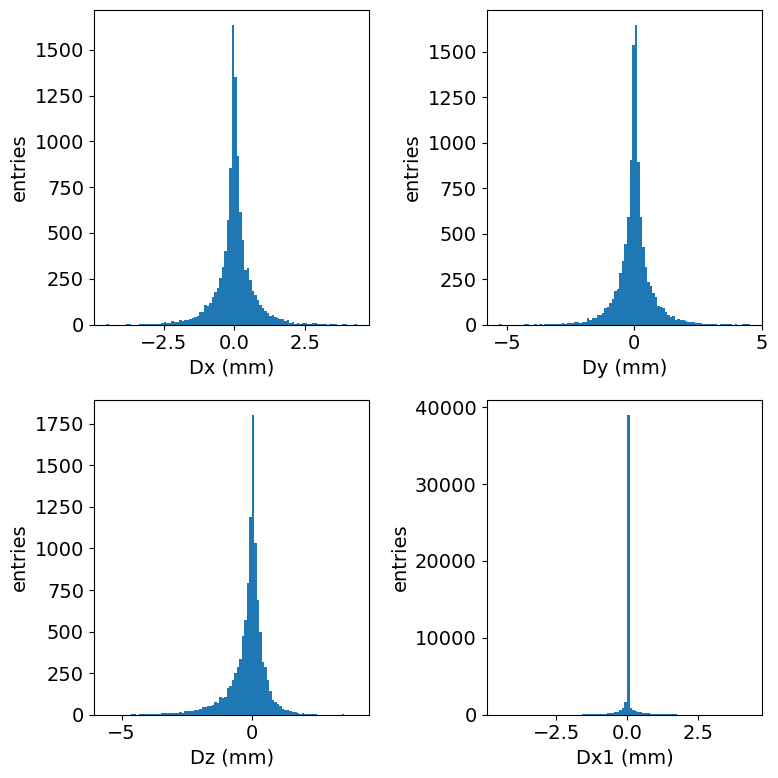

In [46]:
plotboxd(gdfb,bins=100, cut=0.01, figsize=(8,8))

In [47]:
dx =gdfb.x1 - gdfb.xbox
dy =gdfb.y1 - gdfb.ybox
dz =gdfb.z1 - gdfb.zbox
f2gz, f2gx, f2gy = fit_coord(dz[np.abs(dz)>0.01], dx[np.abs(dx)>0.01], dy[np.abs(dy)>0.01], bins=100)

2g fit: mu1 = 0.01, sigma = 0.11, n1  =0.71
2g fit: mu2 = -0.01, sigma = 0.55, n1  =0.29
weighted error: = 0.23
2g fit: mu1 = -0.02, sigma = 0.46, n1  =0.36
2g fit: mu2 = 0.05, sigma = 0.08, n1  =0.64
weighted error: = 0.21
2g fit: mu1 = -0.02, sigma = 0.10, n1  =0.71
2g fit: mu2 = 0.02, sigma = 0.53, n1  =0.29
weighted error: = 0.22


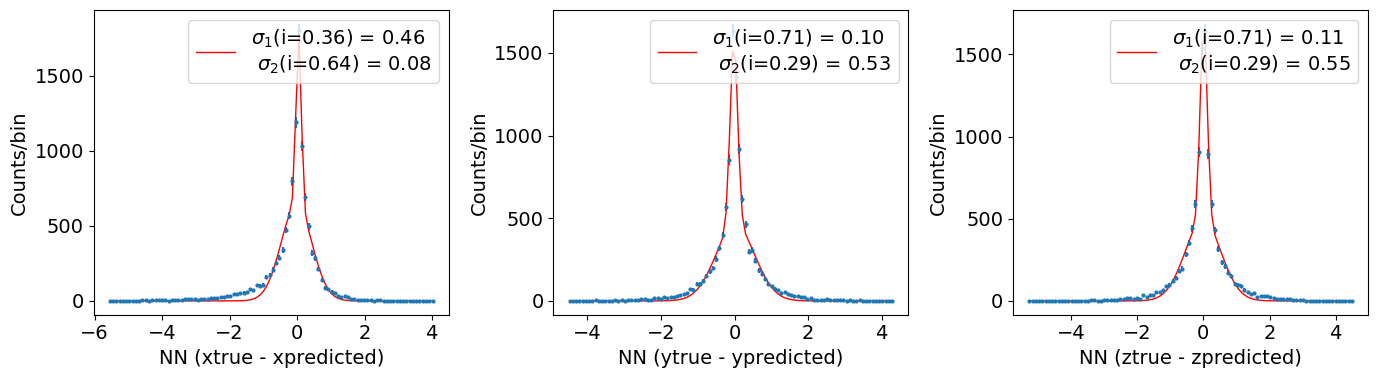

In [48]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

In [49]:
df1c, df2c, dfnc =streams(gdfb, 1, 1)

 fraction of events 1g = 0.59
 fraction of events 2g = 0.33
 fraction of events >3g = 0.09


## Voxelize at 3 mm

In [50]:
gdfb = voxelize(gdf,xyzc,1, sx=3,sy=3,sz=3,case='mono', prnt=1)

nx = 15, ny = 15, nz = 8
number of voxels = 1800
index for xmin =0.0 index for xmax =15.0
index for ymin =0.0 index for ymax =15.0
index for zmin =0.0 index for zmax =8.0


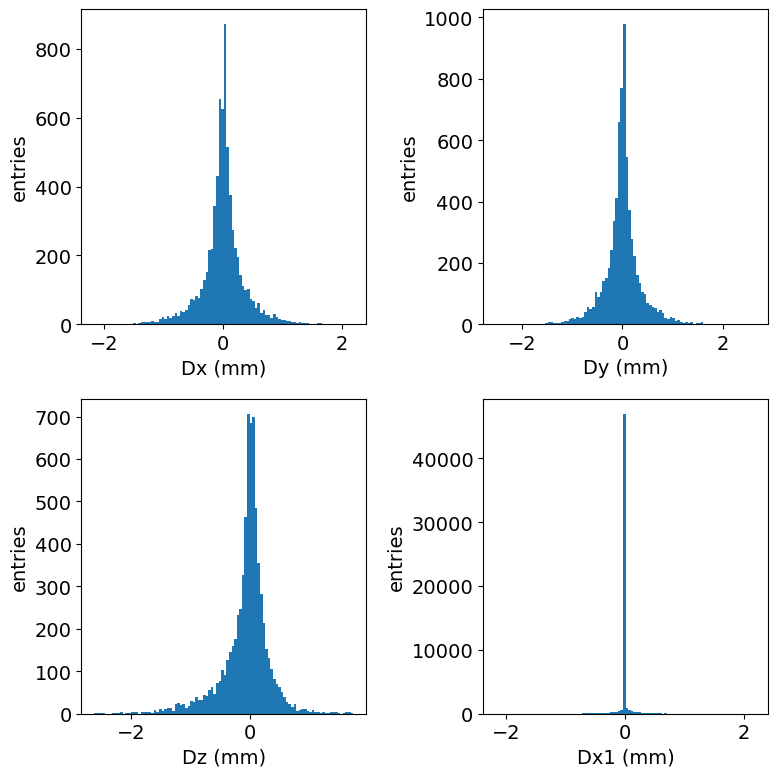

In [51]:
plotboxd(gdfb,bins=100, cut=0.01, figsize=(8,8))

In [52]:
dx =gdfb.x1 - gdfb.xbox
dy =gdfb.y1 - gdfb.ybox
dz =gdfb.z1 - gdfb.zbox
f2gz, f2gx, f2gy = fit_coord(dz[np.abs(dz)>0.01], dx[np.abs(dx)>0.01], dy[np.abs(dy)>0.01], bins=100)

2g fit: mu1 = 0.01, sigma = 0.07, n1  =0.70
2g fit: mu2 = -0.02, sigma = 0.34, n1  =0.30
weighted error: = 0.15
2g fit: mu1 = -0.04, sigma = 0.36, n1  =0.29
2g fit: mu2 = 0.02, sigma = 0.08, n1  =0.71
weighted error: = 0.16
2g fit: mu1 = -0.00, sigma = 0.35, n1  =0.28
2g fit: mu2 = 0.01, sigma = 0.08, n1  =0.72
weighted error: = 0.16


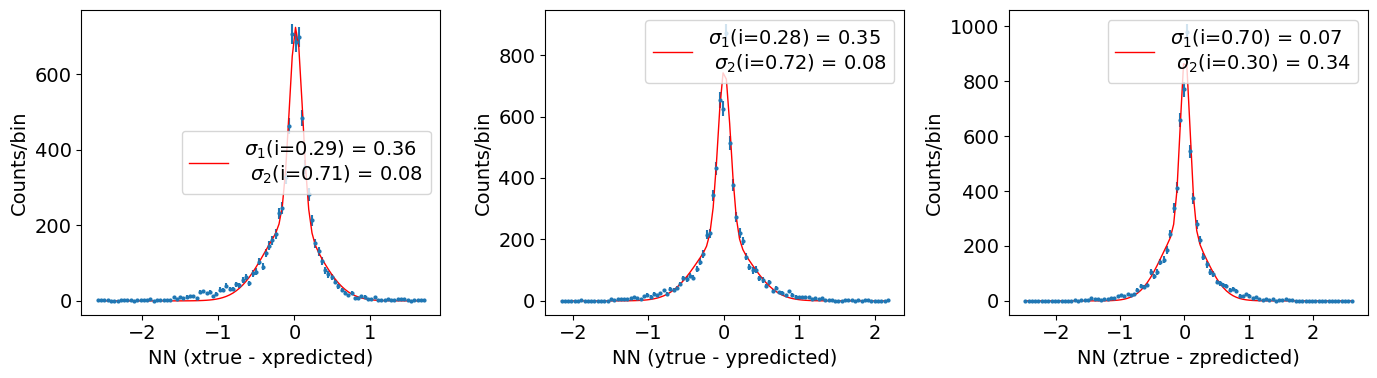

In [53]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

In [54]:
df1c, df2c, dfnc =streams(gdfb, 1, 1)

 fraction of events 1g = 0.50
 fraction of events 2g = 0.36
 fraction of events >3g = 0.14


In [55]:
ntot, nint, df1c, df2c, dfnc =filter_and_voxelize_df(file_paths, xyzc, start=0, end=100, eth=0.001, lmax=50, sx=12,sy=12,sz=12, prnt=10)

Reading data frame 0
Reading data frame 10
Reading data frame 20
Reading data frame 30
Reading data frame 40
Reading data frame 50
Reading data frame 60
Reading data frame 70
Reading data frame 80
Reading data frame 90


In [56]:
print(f"total events = {ntot}, gamma interact in crystal = {nint}")
print(f" fraction of interacting events 1g = {(event_size(df1c)/nint):.2f}")
print(f" fraction of interacting events 2g = {(event_size(df2c)/nint):.2f}")
print(f" fraction of interacting events >2g = {(event_size(dfnc)/nint):.2f}")

total events = 824138, gamma interact in crystal = 642335
 fraction of interacting events 1g = 0.72
 fraction of interacting events 2g = 0.25
 fraction of interacting events >2g = 0.03


In [57]:
df1c.head(10)

,event_id,e,x,y,z,t
0,350003,0.510504,15.731357,-12.959622,0.733635,0.046042
1,350004,0.509777,1.872524,-19.340635,15.218418,0.098708
2,350006,0.509224,14.861016,-20.983425,5.183541,0.062658
3,350007,0.510189,7.272321,-14.548807,9.244444,0.074225
4,350008,0.510827,10.241010,-5.295188,17.577648,0.102239
5,350010,0.511000,23.478945,-19.633455,3.876285,0.056465
6,350012,0.510801,-1.250416,-3.551364,21.314278,0.142909
7,350013,0.508445,-6.134370,-9.479815,13.718153,0.090537
8,350014,0.510249,-17.805731,-5.408090,4.451194,0.063759
9,350015,0.510894,-9.227887,-19.834188,13.390697,0.088223


In [58]:
df2c.head(10)

,event_id,e1,x1,y1,z1,t1,e2,x2,y2,z2,t2,etot
0,350000,0.425383,9.002096,-9.153288,12.413297,0.094226,0.082385,16.179787,-10.170916,2.357410,0.052875,0.507767
1,350001,0.141369,9.626169,-20.355307,18.052013,0.104568,0.367802,13.216259,-23.360641,21.935503,0.124858,0.509171
2,350002,0.320924,-23.652182,-18.856363,10.261168,0.079840,0.189757,-22.734610,-17.350821,8.801526,0.087475,0.510681
3,350018,0.094749,-12.815065,-15.203972,8.165139,0.071591,0.415809,-10.285368,-18.919960,11.834773,0.090948,0.510559
4,350034,0.142228,15.933022,-4.912332,3.770002,0.055630,0.368479,19.140663,2.435163,10.026171,0.089551,0.510708
5,350038,0.120020,12.684438,19.287466,1.243859,0.048574,0.387875,13.281524,19.322165,1.818333,0.051340,0.507894
6,350046,0.283844,16.415310,-0.593883,14.372401,0.103494,0.226346,16.754696,3.192852,13.261173,0.090026,0.510189
7,350047,0.211472,12.524159,-0.806850,3.943067,0.086333,0.298190,10.284235,5.484840,5.744318,0.063259,0.509661
8,350049,0.210377,9.660390,10.010346,9.395330,0.090033,0.300072,6.871436,9.554592,10.249866,0.080185,0.510449
9,350053,0.087691,-16.091543,-23.597658,10.482701,0.100094,0.172413,-3.818961,-23.417900,2.293395,0.050877,0.260105


In [59]:
dfnc.head(10)

,event_id
0,10060
1,10091
2,10141
3,10150
4,10156
5,10261
6,10275
7,10287
8,10298
9,10318


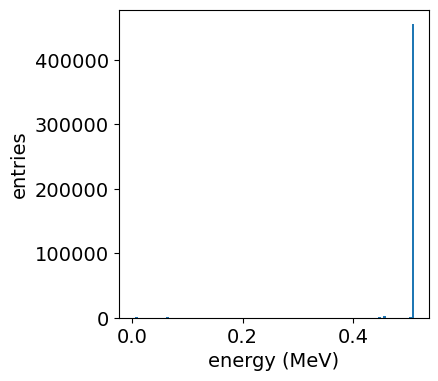

In [60]:
b, e = histoplot(df1c.e, 'energy (MeV)', "entries", bins=100, figsize=(4,4))

In [61]:
def plotd1c(bins=100, figsize=(8,8)):
    fig, ax = plt.subplots(2, 2, figsize=figsize)
    _ = ax[0,0].hist(df1c.x,bins)
    ax[0,0].set_xlabel("x (mm)")
    ax[0,0].set_ylabel("entries")
    #ax[0,0].set_title("x")
    _ = ax[0,1].hist(df1c.y,bins)
    ax[0,1].set_xlabel("y (mm)")
    ax[0,1].set_ylabel("entries")
    _ = ax[1,0].hist(df1c.z,bins)
    ax[1,0].set_xlabel("z (mm)")
    ax[1,0].set_ylabel("entries")
    _ = ax[1,1].hist(df1c.t,bins)
    ax[1,1].set_xlabel("t (ns)")
    ax[1,1].set_ylabel("entries")
    
    fig.tight_layout()
    plt.show()

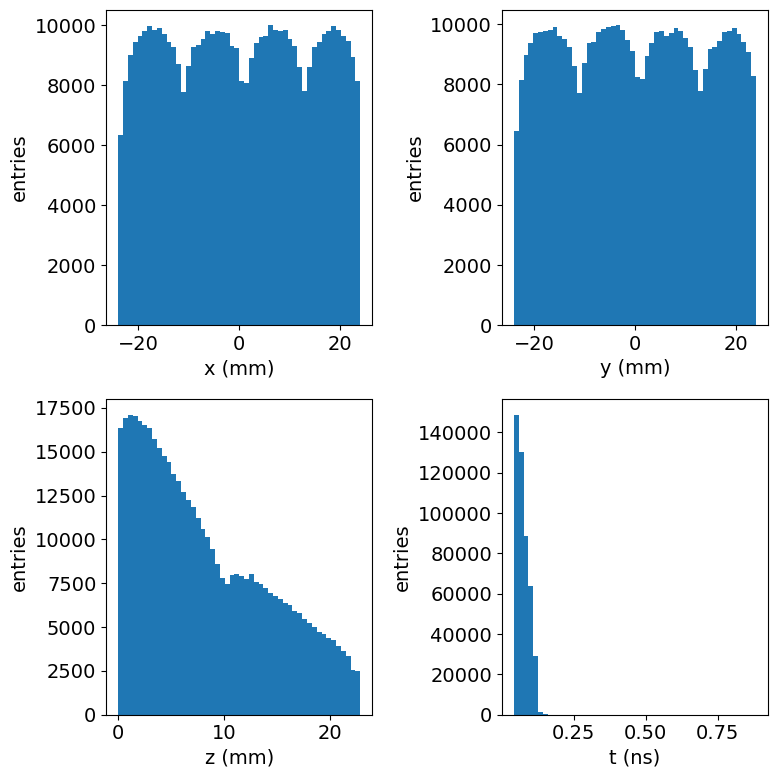

In [62]:
plotd1c(bins=50, figsize=(8,8))

Text(0, 0.5, 'e2 (mm)')

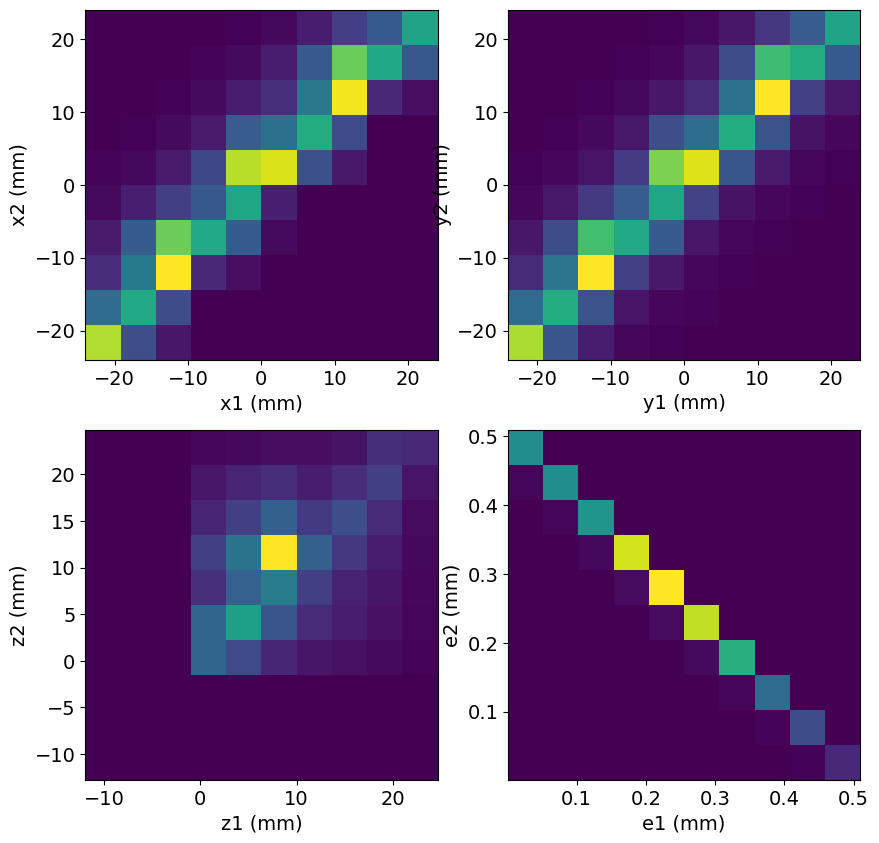

In [63]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))

hxy =ax[0,0].hist2d(df2c.x1, df2c.x2, cmap="viridis",bins=10)
#ax[0].set_aspect('equal')
ax[0,0].set_xlabel('x1 (mm)')
ax[0,0].set_ylabel('x2 (mm)')

hxz =ax[0,1].hist2d(df2c.y1, df2c.y2, cmap="viridis",bins=10)
#ax[1].set_aspect('equal')
ax[0,1].set_xlabel('y1 (mm)')
ax[0,1].set_ylabel('y2 (mm)')

hxz =ax[1,0].hist2d(df2c.z1, df2c.z2, cmap="viridis",bins=10)
#ax[1].set_aspect('equal')
ax[1,0].set_xlabel('z1 (mm)')
ax[1,0].set_ylabel('z2 (mm)')

hxz =ax[1,1].hist2d(df2c.e1, df2c.e2, cmap="viridis",bins=10)
#ax[1].set_aspect('equal')
ax[1,1].set_xlabel('e1 (mm)')
ax[1,1].set_ylabel('e2 (mm)')

In [64]:
def distance():
    return np.sqrt((df2c.x1 - df2c.x2)**2 + (df2c.y1 - df2c.y2)**2 + (df2c.z1 - df2c.z2)**2)

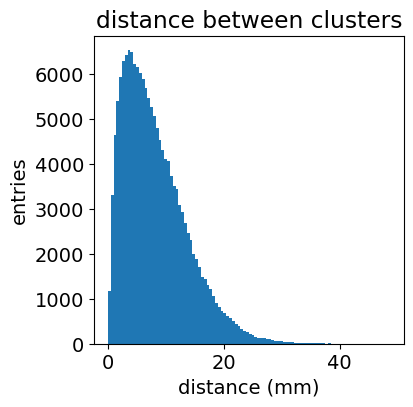

In [65]:
h = histoplot(distance(), "distance (mm)", "entries", bins=100, figsize=(4,4), title="distance between clusters")

In [400]:
df1c.to_csv('df1c.csv', index=False)

In [401]:
df2c.to_csv('df2c.csv', index=False)

In [402]:
dfnc.to_csv('dfnc.csv', index=False)

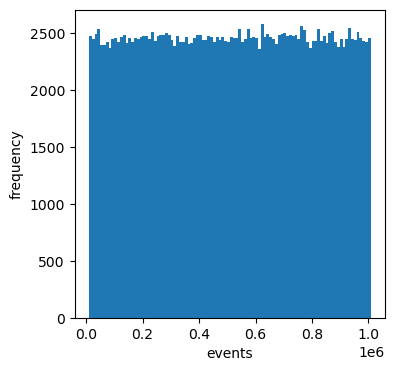

In [412]:
h = histoplot(df1c.event_id, "events", "frequency", bins=100, figsize=(4,4), title="")

In [413]:
df1cs =df1c.sort_values(by='event_id')

df1cs

,event_id,e,x,y,z,t
63683,10004,0.510118,18.645067,12.477487,29.249544,0.116340
63684,10006,0.509274,13.566376,1.647984,21.156849,0.090734
63685,10014,0.509922,-5.014233,5.060986,12.715019,0.062352
63686,10018,0.508170,-22.957691,-9.322307,45.483715,0.171747
63687,10024,0.508948,-3.514938,-0.639491,15.746504,0.074194
...,...,...,...,...,...,...
14600,1007799,0.508742,-23.166395,-11.359650,14.579615,0.067818
14601,1007800,0.508591,4.881050,-3.706980,32.271664,0.126875
14602,1007802,0.509488,-13.702808,23.185465,30.448406,0.123165
14603,1007804,0.509248,-9.634733,17.533094,17.117769,0.076375


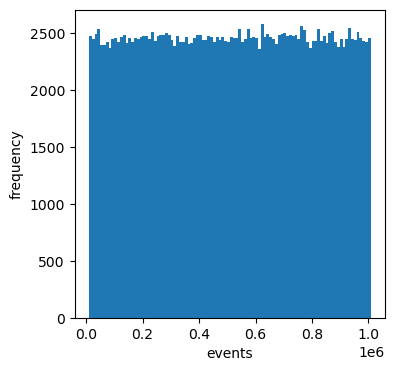

In [414]:
h = histoplot(df1cs.event_id, "events", "frequency", bins=100, figsize=(4,4), title="")

In [417]:
df2cs =df2c.sort_values(by='event_id')
df2cs

,event_id,e1,x1,y1,z1,t1,e2,x2,y2,z2,t2,etot
49899,10003,0.330298,4.990294,0.311470,16.939791,0.091601,0.179934,11.767439,1.126573,13.503364,0.066109,0.510232
49900,10009,0.322141,9.770208,10.759822,43.035156,0.164733,0.186507,12.210072,15.519191,37.142849,0.191277,0.508648
49901,10013,0.265549,6.276037,13.364479,40.609715,0.156441,0.244618,21.409986,-10.269456,37.568260,0.250601,0.510166
49902,10017,0.178680,10.950835,11.677908,17.862885,0.091082,0.329565,13.083003,7.918981,15.518206,0.072993,0.508245
49903,10019,0.130845,3.697574,-9.119902,20.059361,0.088333,0.378074,4.120632,-2.767935,25.876673,0.117098,0.508920
...,...,...,...,...,...,...,...,...,...,...,...,...
11675,1007784,0.390166,-20.912951,-20.125721,30.411863,0.123065,0.118979,-19.904688,-16.910192,27.752243,0.140103,0.509145
11676,1007789,0.268718,6.582607,-13.995539,15.066959,0.070758,0.241255,7.014958,-14.208030,15.030254,0.072369,0.509973
11677,1007797,0.303024,-7.403781,-23.204754,49.368690,0.184981,0.206537,-4.950836,-21.901775,47.709839,0.195792,0.509561
11678,1007798,0.088578,-14.235914,12.100848,19.425718,0.084616,0.420159,-0.171507,15.589924,37.255890,0.161256,0.508737


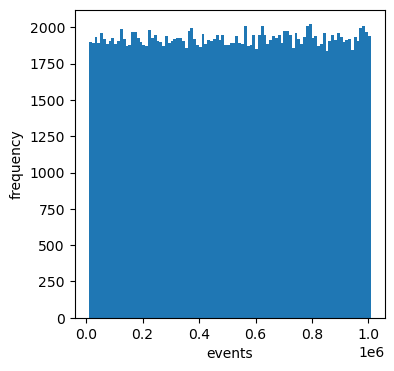

In [418]:
h = histoplot(df2cs.event_id, "events", "frequency", bins=100, figsize=(4,4), title="")

In [420]:
dfncs =dfnc.sort_values(by='event_id')
dfncs

,event_id
0,10001
1,10010
2,10020
3,10039
4,10049
...,...
74667,1007756
74668,1007766
74669,1007770
74670,1007786


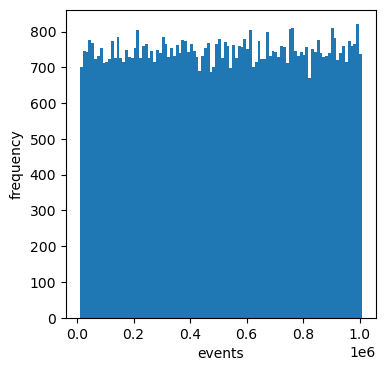

In [421]:
h = histoplot(dfncs.event_id, "events", "frequency", bins=100, figsize=(4,4), title="")